

# Sentiment analysis from movie reviews
## Recurring Neural Networks with Keras


This notebook contains two datasets each containing 25,000 and 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative).

The data set we're using consists of user-generated movie reviews and classification of whether the user liked the movie or not based on its associated rating.

More info on the dataset is here:

https://www.kaggle.com/c/word2vec-nlp-tutorial/data

https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification


We are going to use an RNN to do sentiment analysis on full-text movie reviews.

We're going to train an artificial neural network how to "read" movie reviews and guess  whether the author liked the movie or not from them.

Since understanding written language requires keeping track of all the words in a sentence, we need a recurrent neural network to keep a "memory" of the words that have come before as it "reads" sentences over time.

In particular, we'll use LSTM (Long Short-Term Memory) cells because we don't really want to "forget" words too quickly - words early on in a sentence can affect the meaning of that sentence significantly.

Let's start by importing the stuff we need:

In [1]:
import pandas as pd
import nltk
import re
import string
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


#Keras import
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
from tensorflow.keras.models import Sequential

/Users/nihithindlekar/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
#Read the data
df2 = pd.read_csv("imdb_master.csv", encoding= "latin-1" )
df2.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [ ]:
df1 = pd.read_csv("labeledTrainData.tsv", sep = ' ')
df1 = df1.drop("id", axis=1)
df1.head()

In [4]:
#Dropping the irrelevant features from dataset
df2.drop(["Unnamed: 0", "file", "type"],  axis=1, inplace=True)
df2.columns = ["review", "sentiment"]
df2 = df2[df2["sentiment"] != 'unsup']
df2["sentiment"] = df2["sentiment"].map({"pos": 1, "neg": 0})

In [5]:
#checking dimensions
df2.shape

(50000, 2)

In [6]:
df1.shape

(25000, 2)

In [7]:
#Concatenating bot the datasets into one df for better predictions
df = pd.concat([df1, df2]).reset_index(drop=True)
df.head()

/Users/nihithindlekar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,review,sentiment
0,With all this stuff going down at the moment w...,1
1,"\The Classic War of the Worlds\"" by Timothy Hi...",1
2,The film starts with a manager (Nicholas Bell)...,0
3,It must be assumed that those who praised this...,0
4,Superbly trashy and wondrously unpretentious 8...,1


In [8]:
#checking dim
df.shape

(75000, 2)

In [9]:
df["sentiment"].value_counts()

1    37500
0    37500
Name: sentiment, dtype: int64

In [11]:
df["length"] = df["review"].apply(len)
df.head()

,review,sentiment,length
0,With all this stuff going down at the moment w...,1,2302
1,"\The Classic War of the Worlds\"" by Timothy Hi...",1,946
2,The film starts with a manager (Nicholas Bell)...,0,2449
3,It must be assumed that those who praised this...,0,2245
4,Superbly trashy and wondrously unpretentious 8...,1,2231


In [12]:
df["length"].describe()

count    75000.000000
mean      1315.683627
std        995.151354
min         32.000000
25%        700.000000
50%        974.000000
75%       1598.000000
max      13708.000000
Name: length, dtype: float64

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a369b16a0>,
      dtype=object)

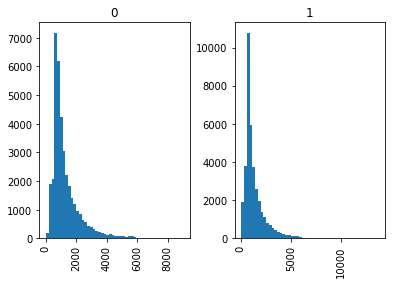

In [15]:
df.hist(column='length', by= 'sentiment', bins=50)

In [101]:
#defining the stopwords and lemmatizer
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

#defining a function for text processing 
def clean_text(text):
    nopunc = [c for c in text if c not in string.punctuation]
    nopunc = ''.join(nopunc)
    text = nopunc.lower()
    text = [word for word in text.split() if word.lower() not in stop_words]
    text = [lemmatizer.lemmatize(token, 'v') for token in text]
    text = " ".join(text)
    return text




df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))

## Modelling

In [103]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

RNN's can blow up quickly, so again to keep things managable on our little PC let's limit the reviews to their first 80 words:

In [104]:
maxlen = 130
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = df['sentiment']

In [105]:
X_t[0]

array([   3,  117,   15,   22,    5,  117,  199,   17,  244, 1814,    1,
        677,  264,    2,  121,  331,   85,  823,  151, 3501, 1504,  324,
        827,  520,  852,  664, 1341,   45,  285,   29,  575,  563,  827,
         11, 3708,   45,   26,   24, 2946,  664,  478,  190,  762,    1,
         64,  512,   98,    6,   94,  436, 2115,  136, 1567, 2401,  324,
         27,   92,  132, 4220, 3709,   37,    2,   29,  324,  511,  582,
        663,   44,    4,  140,  156,  522,  136,  638,  886, 1133,  397,
       3602,    1, 1140,  122,    3,   26,    6,    4,  456,   77,   16,
         26,  413,  167,   50,   30,  549, 3083, 1757,    3,  174,  417,
       1596,  279,    4,  898,   26,   53, 1239, 1112, 2089,   20,  594,
        111,   30,   20,   33,   24,   26,  189,  431,  368, 3001,   24,
        104,  280,  470,  244,  291,   72,    4,  345, 1400], dtype=int32)

In [106]:
y.head()

0    1
1    1
2    0
3    0
4    1
Name: sentiment, dtype: int64

## Training the model

Now let's set up our neural network model

We will start with an Embedding layer - this is just a step that converts the input data into dense vectors of fixed size that's better suited for a neural network. You generally see this in conjunction with index-based text data like we have here. The 20,000 indicates the vocabulary size (remember we said we only wanted the top 20,000 words) and 128 is the output dimension of 128 units.

Next we just have to set up a LSTM layer for the RNN itself. It's that easy. We specify 128 to match the output size of the Embedding layer, and dropout terms to avoid overfitting, which RNN's are particularly prone to.

Finally we just need to boil it down to a single neuron with a sigmoid activation function to choose our binay sentiment classification of 0 or 1.

In [107]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128))
model.add(Dense(1, activation= "relu"))
model.add(Dense(1, activation = "sigmoid"))


As this is a binary classification problem, we'll use the binary_crossentropy loss function. And the Adam optimizer is usually a good choice (feel free to try others.)

In [108]:
model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics=['accuracy'])

In [76]:
model.fit(X_t, y, batch_size = 100, epochs = 3, validation_split= 0.2)

/Users/nihithindlekar/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 60000 samples, validate on 15000 samples
Epoch 1/3
60000/60000 [==============================] - 263s 4ms/step - loss: 0.4404 - acc: 0.8321 - val_loss: 0.5015 - val_acc: 0.9117
Epoch 2/3
60000/60000 [==============================] - 241s 4ms/step - loss: 0.3266 - acc: 0.8955 - val_loss: 0.3789 - val_acc: 0.9370
Epoch 3/3
60000/60000 [==============================] - 226s 4ms/step - loss: 0.2685 - acc: 0.9137 - val_loss: 0.3053 - val_acc: 0.9369


## Model Evaluation

In [77]:
#Read the test data for evaluating model
df_test=pd.read_csv("testData.tsv",header=0, delimiter="\t", quoting=3)
df_test.head()

df_test["review"]=df_test.review.apply(lambda x: clean_text(x))
df_test["sentiment"] = df_test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

y_test = df_test["sentiment"]
list_sentences_test = df_test["review"]

list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
prediction = model.predict(X_te)
y_pred = (prediction > 0.5)


from sklearn.metrics import f1_score, confusion_matrix
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

F1-score: 0.9340246170894843
Confusion matrix:


array([[11533,   700],
       [  967, 11800]])